In [1]:
import pandas as pd
import tabensemb
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

tabensemb.setting["matplotlib_usetex"] = True
tabensemb._stream_filters = ["DeprecationWarning"]

from tabensemb.trainer import load_trainer
import matplotlib


# Random

In [2]:
trainer = load_trainer("output/composite_database_10082023/2023-12-14-23-09-20-0_composite Random 622 extracted/trainer.pkl")

## Physics/DL weight

In [ ]:
import os
import numpy as np
thiswork = trainer.get_modelbase(program="ThisWork")
train_weights = pd.DataFrame(columns=[x for x in thiswork.get_model_names() if "PHYSICS" not in x], index=trainer.train_indices)
val_weights = pd.DataFrame(columns=[x for x in thiswork.get_model_names() if "PHYSICS" not in x], index=trainer.val_indices)
test_weights = pd.DataFrame(columns=[x for x in thiswork.get_model_names() if "PHYSICS" not in x], index=trainer.test_indices)
for idx, model_name in enumerate(thiswork.get_model_names()):
    if "PHYSICS" not in model_name:
        res = thiswork.inspect_weighted_predictions(model_name=model_name)
        train_weights[model_name] = res["train"]["dl_weight"]
        val_weights[model_name] = res["val"]["dl_weight"]
        test_weights[model_name] = res["test"]["dl_weight"]

In [4]:
x_cluster = thiswork.inspect_attr(
            model_name="PHYSICS_NoPCA_KMeans", attributes=["x_cluster"]
        )

## Weights in different clusters

In [ ]:
plt.figure(figsize=(10, 3), dpi=400)
plt.scatter(x_cluster["train"]["x_cluster"], train_weights.values[:, 3], linewidths=0, alpha=0.2)
plt.show()
plt.close()

## size versus weight

In [ ]:
from scipy.stats import pearsonr

plt.figure()
cnt_weights = []
for i in range(np.max(x_cluster["train"]["x_cluster"])):
    is_this_cluster = np.where(x_cluster["train"]["x_cluster"]==i)[0]
    cnt_weights.append((len(is_this_cluster), train_weights.mean(axis=1).values[is_this_cluster]))
# plt.scatter(x_cluster["train"]["x_cluster"], train_weights.values[:, 3], linewidths=0, alpha=0.2)
x = [x[0] for x in cnt_weights if x[0]!=0]
y = [np.mean(x[1]) for x in cnt_weights if x[0]!=0]
plt.scatter(x, y)
r = pearsonr(x, y)
print(r)
pfit = np.polyfit(x, y, 1)
k, b = pfit[0], pfit[1]
plt.plot(np.linspace(0, 40, 3), k*np.linspace(0, 40, 3)+b, color="k", label="Linear fitting")
plt.show()
plt.close()

## distance versus weight

In [ ]:
plt.figure()
model = thiswork.model["PHYSICS_NoPCA_KMeans"]
cnt_weights = []
for i in range(np.max(x_cluster["train"]["x_cluster"])):
    is_this_cluster = np.where(x_cluster["train"]["x_cluster"]==i)[0]
    cnt_weights.append((len(is_this_cluster), np.sqrt(np.sum(np.power(model.clustering.centers[i, :].cpu().numpy(), 2))), train_weights.mean(axis=1).values[is_this_cluster]))
# plt.scatter(x_cluster["train"]["x_cluster"], train_weights.values[:, 3], linewidths=0, alpha=0.2)
x = [x[1] for x in cnt_weights if x[0]!=0]
y = [np.mean(x[2]) for x in cnt_weights if x[0]!=0]
plt.scatter(x, y)
r = pearsonr(x, y)
print(r)
pfit = np.polyfit(x, y, 1)
k, b = pfit[0], pfit[1]
plt.plot(np.linspace(0, 40, 3), k*np.linspace(0, 40, 3)+b, color="k", label="Linear fitting")
plt.xlim([0, 15])
plt.show()
plt.close()

## weight distribution in train/val/test

In [ ]:
plt.figure()
ax = plt.subplot(111)
sns.kdeplot(train_weights.mean(axis=1), label="train", ax=ax, color=tabensemb.utils.global_palette[0])
sns.kdeplot(val_weights.mean(axis=1), label="val", ax=ax, color=tabensemb.utils.global_palette[1])
sns.kdeplot(test_weights.mean(axis=1), label="test", ax=ax, color=tabensemb.utils.global_palette[2])
plt.legend()
plt.show()
plt.close()

Not normal distributed along the model axis:

In [ ]:
pvals = [st.shapiro(train_weights.loc[idx, :]).pvalue for idx in train_weights.index]
sns.histplot(pvals, bins=20)

## Correlation of weights among models

In [ ]:
plt.figure(figsize=(10, 3))
ax = plt.subplot(131)
im = ax.imshow(train_weights.corr())
plt.colorbar(mappable=im)
ax = plt.subplot(132)
im = ax.imshow(train_weights.corr(method="kendall"))
plt.colorbar(mappable=im)
ax = plt.subplot(133)
im = ax.imshow(train_weights.corr(method="spearman"))
plt.colorbar(mappable=im)
plt.show()
plt.close()

Clear correlation though modest between each two models, thus we can to analyse the average of dl train_weights of different models.

In [ ]:
plt.figure(figsize=(10, 3))
ax = plt.subplot(131)
im = ax.imshow(train_weights.corr()>0.3)
plt.colorbar(mappable=im)
ax = plt.subplot(132)
im = ax.imshow(train_weights.corr(method="kendall")>0.3)
plt.colorbar(mappable=im)
ax = plt.subplot(133)
im = ax.imshow(train_weights.corr(method="spearman")>0.3)
plt.colorbar(mappable=im)
plt.show()
plt.close()

## Preference of ML/physics

No clear preference of ML/physics considering high-cycle or low-cycle data

In [ ]:
plt.figure()
avg_weights = train_weights.mean(axis=1)
plt.scatter(trainer.df.loc[trainer.train_indices, trainer.label_name], avg_weights, alpha=0.1, linewidths=0)
plt.show()
plt.close()

No clear preference of ML/physics considering frequency difference

In [ ]:
plt.figure()
plt.scatter(trainer.df.loc[trainer.train_indices, ["Frequency"]], avg_weights, alpha=0.05, linewidths=0)
plt.xlim([0, 10])
plt.show()
plt.close()

No clear preference of ML/physics considering stress difference

In [ ]:
plt.figure()
plt.scatter(trainer.df.loc[trainer.train_indices, ["Relative Maximum Stress"]], avg_weights, alpha=0.1, linewidths=0)
# plt.xlim([0, 10])
plt.show()
plt.close()

In [ ]:
plt.figure()
plt.scatter(trainer.df.loc[trainer.train_indices, ["Relative Maximum Stress"]], avg_weights, alpha=0.1, linewidths=0)
# plt.xlim([0, 10])
plt.show()
plt.close()

No clear preference of ML/physics considering R-value difference

In [ ]:
plt.figure()
plt.scatter(trainer.df.loc[trainer.train_indices, ["R-value"]], avg_weights, alpha=0.05, linewidths=0)
# plt.xlim([0, 10])
plt.show()
plt.close()

In [ ]:
plt.figure()
ax = plt.subplot(111)
unique_values = np.unique(trainer.df["R-value"])
for idx, r_val in enumerate(unique_values):
    indices = trainer.datamodule.select_by_value(selection={"R-value": r_val}, partition="train")
    sns.kdeplot(data=avg_weights.loc[indices], ax=ax, label=str(round(r_val, 1)), color="blue", alpha=(idx+1)/len(unique_values))
plt.legend()
plt.show()
plt.close()

In [ ]:
plt.figure()
ax = plt.subplot(111)
ranges = [(-10, 0), (0, 1), (1, 20)]
for idx, r_val in enumerate(ranges):
    indices = trainer.datamodule.select_by_value(selection={"R-value": r_val}, partition="train")
    sns.kdeplot(data=avg_weights.loc[indices], ax=ax, label=str(r_val), color="blue", alpha=(idx+1)/len(ranges))
plt.legend()
plt.show()
plt.close()

Weak trend observed from weights versus number of data points

/tmp/ipykernel_10020/2307040306.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=avg_weights.loc[indices], ax=ax, label=str(round(r_val, 1)), color="blue", alpha=(idx+1)/len(unique_values))
/tmp/ipykernel_10020/2307040306.py:6: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=avg_weights.loc[indices], ax=ax, label=str(round(r_val, 1)), color="blue", alpha=(idx+1)/len(unique_values))


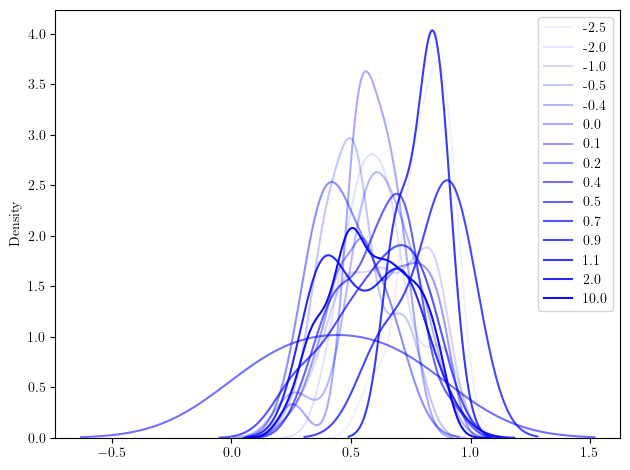

In [76]:
plt.figure()
ax = plt.subplot(111)
unique_values = np.unique(trainer.df["R-value"])
for idx, r_val in enumerate(unique_values):
    indices = trainer.datamodule.select_by_value(selection={"R-value": r_val}, partition="train")
    sns.kdeplot(data=avg_weights.loc[indices], ax=ax, label=str(round(r_val, 1)), color="blue", alpha=(idx+1)/len(unique_values))
plt.legend()
plt.show()
plt.close()

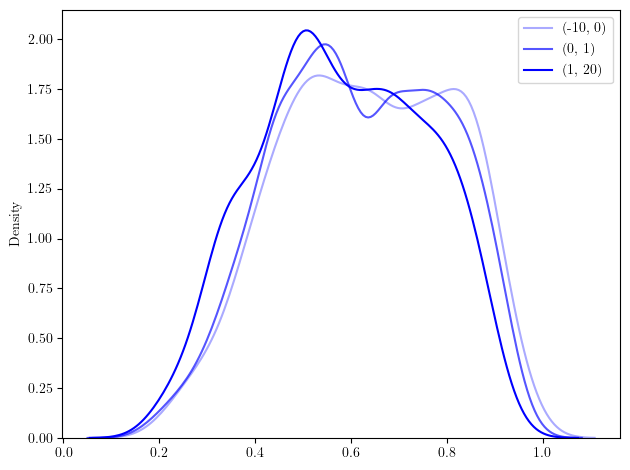

In [77]:
plt.figure()
ax = plt.subplot(111)
ranges = [(-10, 0), (0, 1), (1, 20)]
for idx, r_val in enumerate(ranges):
    indices = trainer.datamodule.select_by_value(selection={"R-value": r_val}, partition="train")
    sns.kdeplot(data=avg_weights.loc[indices], ax=ax, label=str(r_val), color="blue", alpha=(idx+1)/len(ranges))
plt.legend()
plt.show()
plt.close()

Weak trend observed from weights versus number of data points

In [ ]:
cnt_weights = []
mat_code_set = list(sorted(set(trainer.df["Material_Code"])))
for c in mat_code_set:
    indices = trainer.select_by_material_code(m_code=c, partition="train")
    cnt_weights.append((len(indices), avg_weights.loc[indices]))

In [ ]:
cnt_weights

# Cycle

In [2]:
trainer = load_trainer("output/composite_database_10082023/2023-12-17-21-22-17-0_composite StressCycle 622 extracted/trainer.pkl")

In [13]:
import os
import numpy as np
thiswork = trainer.get_modelbase(program="ThisWork")
train_weights = pd.DataFrame(columns=[x for x in thiswork.get_model_names() if "PHYSICS" not in x], index=trainer.train_indices)
val_weights = pd.DataFrame(columns=[x for x in thiswork.get_model_names() if "PHYSICS" not in x], index=trainer.val_indices)
test_weights = pd.DataFrame(columns=[x for x in thiswork.get_model_names() if "PHYSICS" not in x], index=trainer.test_indices)
train_prediction = train_weights.copy()
val_prediction = val_weights.copy()
test_prediction = test_weights.copy()
train_phy_prediction = train_weights.copy()
val_phy_prediction = val_weights.copy()
test_phy_prediction = test_weights.copy()
train_ml_prediction = train_weights.copy()
val_ml_prediction = val_weights.copy()
test_ml_prediction = test_weights.copy()
for idx, model_name in enumerate(thiswork.get_model_names()):
    if "PHYSICS" not in model_name:
        res = thiswork.inspect_weighted_predictions(model_name=model_name)
        train_weights[model_name] = res["train"]["dl_weight"]
        val_weights[model_name] = res["val"]["dl_weight"]
        test_weights[model_name] = res["test"]["dl_weight"]
        train_prediction[model_name] = res["train"]["prediction"]
        val_prediction[model_name] = res["val"]["prediction"]
        test_prediction[model_name] = res["test"]["prediction"]
        train_ml_prediction[model_name] = res["train"]["dl_pred"]
        val_ml_prediction[model_name] = res["val"]["dl_pred"]
        test_ml_prediction[model_name] = res["test"]["dl_pred"]
        train_phy_prediction[model_name] = res["train"]["phy_pred"]
        val_phy_prediction[model_name] = res["val"]["phy_pred"]
        test_phy_prediction[model_name] = res["test"]["phy_pred"]

In [6]:
x_cluster = thiswork.inspect_attr(
            model_name="PHYSICS_NoPCA_KMeans", attributes=["x_cluster"]
        )

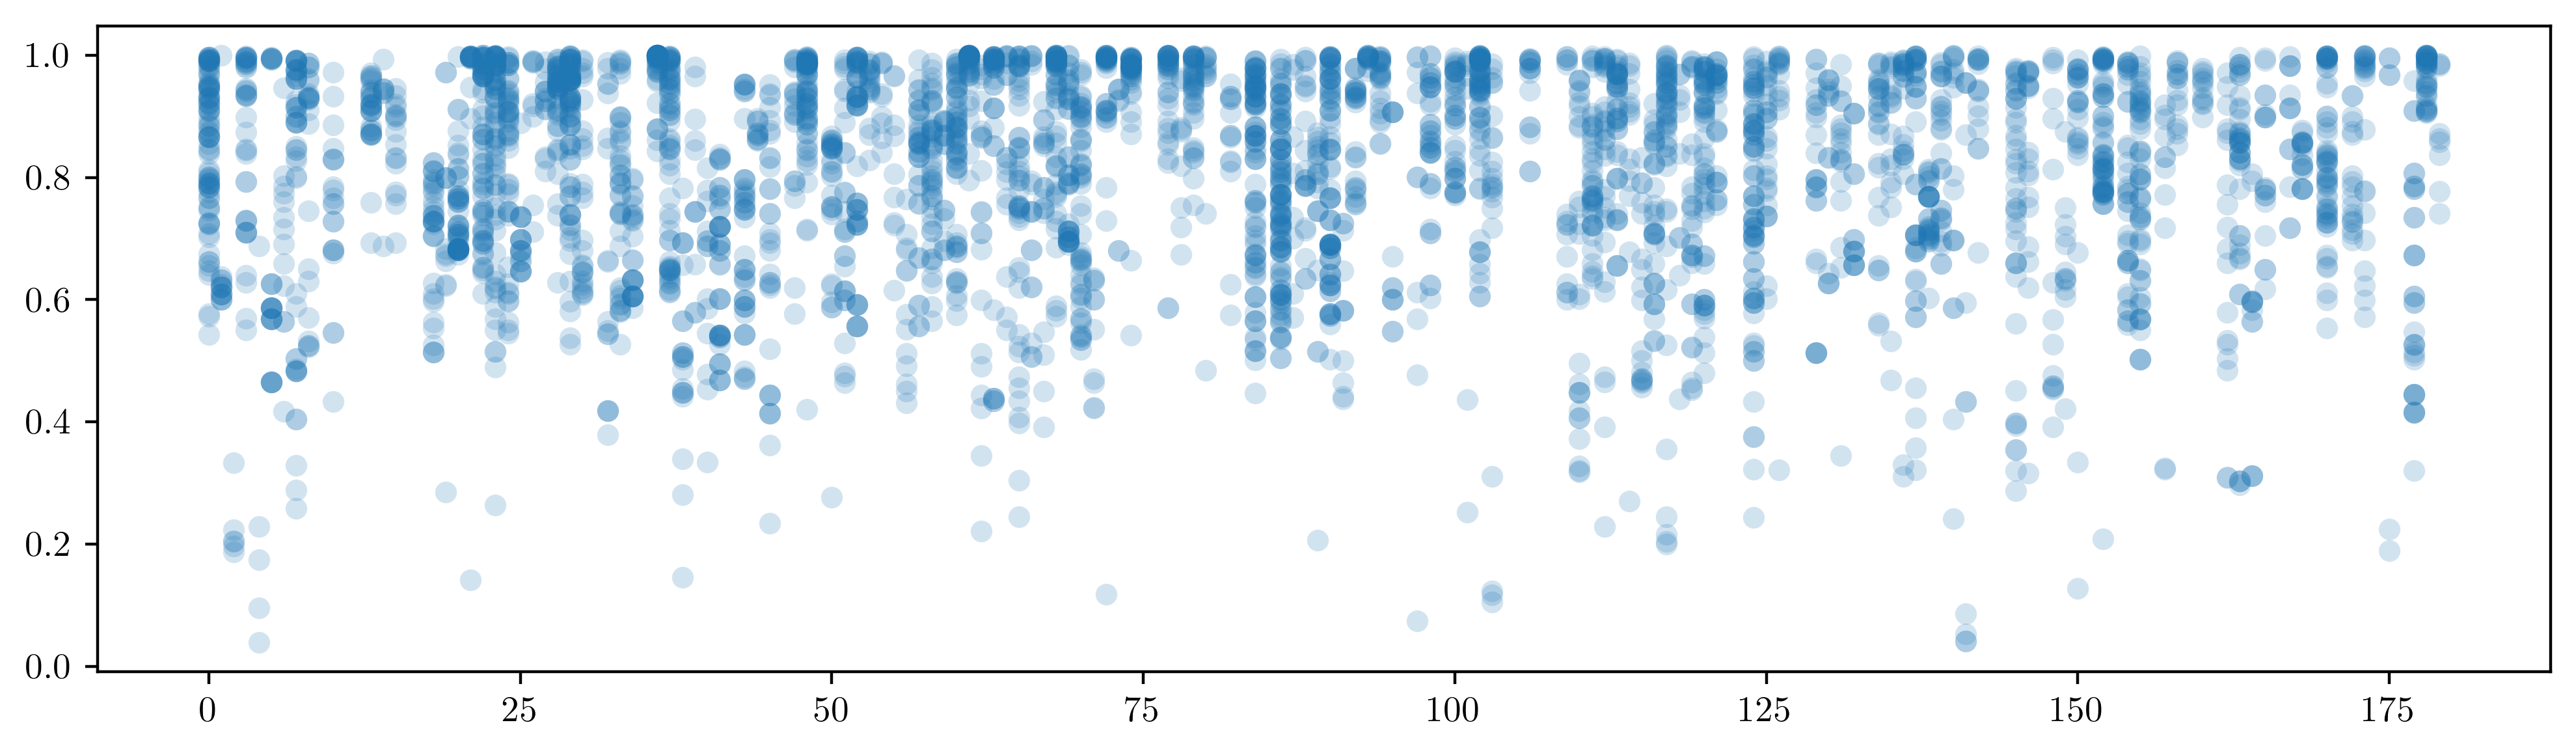

In [7]:
plt.figure(figsize=(10, 3), dpi=400)
plt.scatter(x_cluster["train"]["x_cluster"], train_weights.values[:, 3], linewidths=0, alpha=0.2)
plt.show()
plt.close()

PearsonRResult(statistic=0.3829316597592347, pvalue=3.0188377006450187e-06)


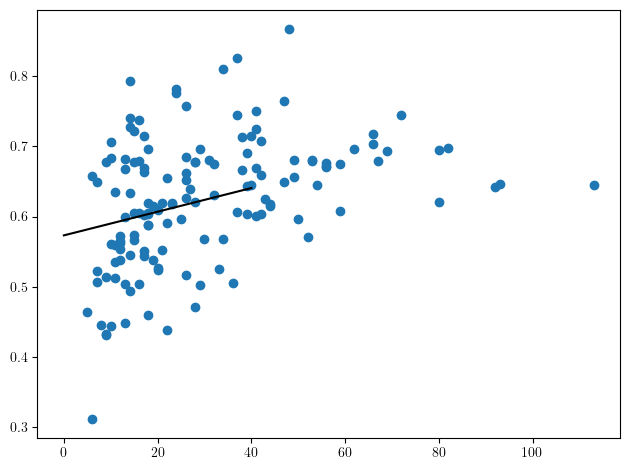

In [8]:
from scipy.stats import pearsonr

plt.figure()
cnt_weights = []
for i in range(np.max(x_cluster["train"]["x_cluster"])):
    is_this_cluster = np.where(x_cluster["train"]["x_cluster"]==i)[0]
    cnt_weights.append((len(is_this_cluster), train_weights.mean(axis=1).values[is_this_cluster]))
# plt.scatter(x_cluster["train"]["x_cluster"], train_weights.values[:, 3], linewidths=0, alpha=0.2)
x = [x[0] for x in cnt_weights if x[0]!=0]
y = [np.mean(x[1]) for x in cnt_weights if x[0]!=0]
plt.scatter(x, y)
r = pearsonr(x, y)
print(r)
pfit = np.polyfit(x, y, 1)
k, b = pfit[0], pfit[1]
plt.plot(np.linspace(0, 40, 3), k*np.linspace(0, 40, 3)+b, color="k", label="Linear fitting")
plt.show()
plt.close()

PearsonRResult(statistic=-0.23071047319514962, pvalue=0.0060986862365477)


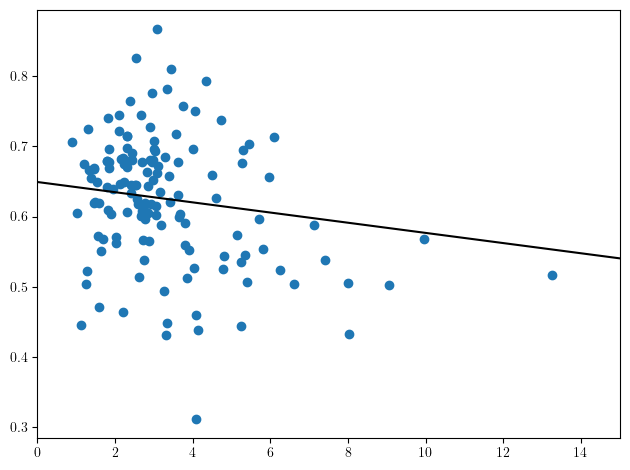

In [9]:
plt.figure()
model = thiswork.model["PHYSICS_NoPCA_KMeans"]
cnt_weights = []
for i in range(np.max(x_cluster["train"]["x_cluster"])):
    is_this_cluster = np.where(x_cluster["train"]["x_cluster"]==i)[0]
    cnt_weights.append((len(is_this_cluster), np.sqrt(np.sum(np.power(model.clustering.centers[i, :].cpu().numpy(), 2))), train_weights.mean(axis=1).values[is_this_cluster]))
# plt.scatter(x_cluster["train"]["x_cluster"], train_weights.values[:, 3], linewidths=0, alpha=0.2)
x = [x[1] for x in cnt_weights if x[0]!=0]
y = [np.mean(x[2]) for x in cnt_weights if x[0]!=0]
plt.scatter(x, y)
r = pearsonr(x, y)
print(r)
pfit = np.polyfit(x, y, 1)
k, b = pfit[0], pfit[1]
plt.plot(np.linspace(0, 40, 3), k*np.linspace(0, 40, 3)+b, color="k", label="Linear fitting")
plt.xlim([0, 15])
plt.show()
plt.close()

PearsonRResult(statistic=0.19636087059082102, pvalue=0.020059780632442042)
PearsonRResult(statistic=-0.008969122082969133, pvalue=0.9162371516195347)


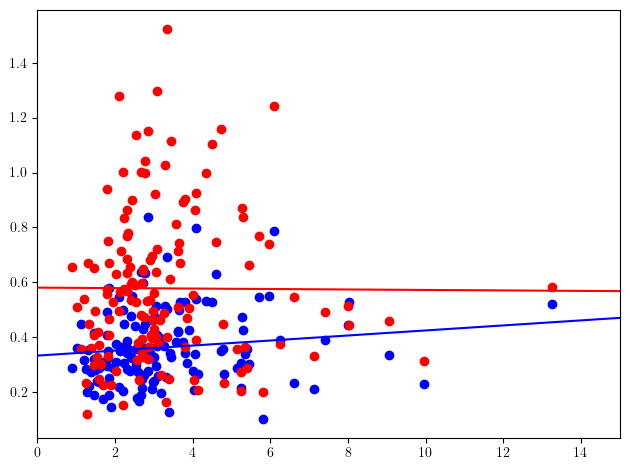

In [22]:
from tabensemb.utils import metric_sklearn

plt.figure()

model = thiswork.model["PHYSICS_NoPCA_KMeans"]
cnt_weights = []
for i in range(np.max(x_cluster["train"]["x_cluster"])):
    is_this_cluster = np.where(x_cluster["train"]["x_cluster"]==i)[0]
    ml_rmse = metric_sklearn(trainer.df.loc[trainer.train_indices[is_this_cluster], trainer.label_name], train_ml_prediction.mean(axis=1).values[is_this_cluster], metric="rmse") if len(is_this_cluster)>0 else np.nan
    phy_rmse = metric_sklearn(trainer.df.loc[trainer.train_indices[is_this_cluster], trainer.label_name], train_phy_prediction.mean(axis=1).values[is_this_cluster], metric="rmse") if len(is_this_cluster)>0 else np.nan
    cnt_weights.append((len(is_this_cluster), np.sqrt(np.sum(np.power(model.clustering.centers[i, :].cpu().numpy(), 2))), train_weights.mean(axis=1).values[is_this_cluster], ml_rmse, phy_rmse))
# plt.scatter(x_cluster["train"]["x_cluster"], train_weights.values[:, 3], linewidths=0, alpha=0.2)
x = [x[1] for x in cnt_weights if x[0]!=0]
y = [x[3] for x in cnt_weights if x[0]!=0]
plt.scatter(x, y, c="b")
r = pearsonr(x, y)
print(r)
pfit = np.polyfit(x, y, 1)
k, b = pfit[0], pfit[1]
plt.plot(np.linspace(0, 40, 3), k*np.linspace(0, 40, 3)+b, color="b", label="Linear fitting (distance vs ml rmse)")
plt.xlim([0, 15])

x = [x[1] for x in cnt_weights if x[0]!=0]
y = [x[4] for x in cnt_weights if x[0]!=0]
plt.scatter(x, y, c="r")
r = pearsonr(x, y)
print(r)
pfit = np.polyfit(x, y, 1)
k, b = pfit[0], pfit[1]
plt.plot(np.linspace(0, 40, 3), k*np.linspace(0, 40, 3)+b, color="r", label="Linear fitting (distance vs phy rmse)")
plt.xlim([0, 15])


plt.show()
plt.close()

PearsonRResult(statistic=0.047366683371476224, pvalue=0.5783902908051031)
PearsonRResult(statistic=0.32389384979019287, pvalue=9.470430430337859e-05)


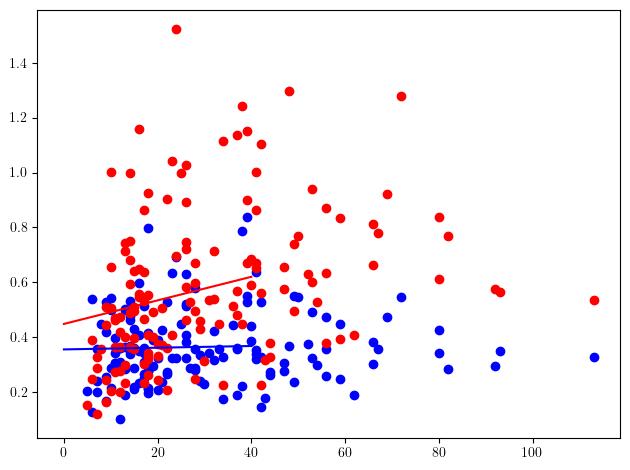

In [25]:
from tabensemb.utils import metric_sklearn

plt.figure()

model = thiswork.model["PHYSICS_NoPCA_KMeans"]
cnt_weights = []
for i in range(np.max(x_cluster["train"]["x_cluster"])):
    is_this_cluster = np.where(x_cluster["train"]["x_cluster"]==i)[0]
    ml_rmse = metric_sklearn(trainer.df.loc[trainer.train_indices[is_this_cluster], trainer.label_name], train_ml_prediction.mean(axis=1).values[is_this_cluster], metric="rmse") if len(is_this_cluster)>0 else np.nan
    phy_rmse = metric_sklearn(trainer.df.loc[trainer.train_indices[is_this_cluster], trainer.label_name], train_phy_prediction.mean(axis=1).values[is_this_cluster], metric="rmse") if len(is_this_cluster)>0 else np.nan
    cnt_weights.append((len(is_this_cluster), np.sqrt(np.sum(np.power(model.clustering.centers[i, :].cpu().numpy(), 2))), train_weights.mean(axis=1).values[is_this_cluster], ml_rmse, phy_rmse))
# plt.scatter(x_cluster["train"]["x_cluster"], train_weights.values[:, 3], linewidths=0, alpha=0.2)
x = [x[0] for x in cnt_weights if x[0]!=0]
y = [x[3] for x in cnt_weights if x[0]!=0]
plt.scatter(x, y, c="b")
r = pearsonr(x, y)
print(r)
pfit = np.polyfit(x, y, 1)
k, b = pfit[0], pfit[1]
plt.plot(np.linspace(0, 40, 3), k*np.linspace(0, 40, 3)+b, color="b", label="Linear fitting (n points vs ml rmse)")

x = [x[0] for x in cnt_weights if x[0]!=0]
y = [x[4] for x in cnt_weights if x[0]!=0]
plt.scatter(x, y, c="r")
r = pearsonr(x, y)
print(r)
pfit = np.polyfit(x, y, 1)
k, b = pfit[0], pfit[1]
plt.plot(np.linspace(0, 40, 3), k*np.linspace(0, 40, 3)+b, color="r", label="Linear fitting (n points vs phy rmse)")

plt.show()
plt.close()

PearsonRResult(statistic=0.08145510787150295, pvalue=0.3386985113612353)
PearsonRResult(statistic=0.03223689212380203, pvalue=0.7053484038473333)


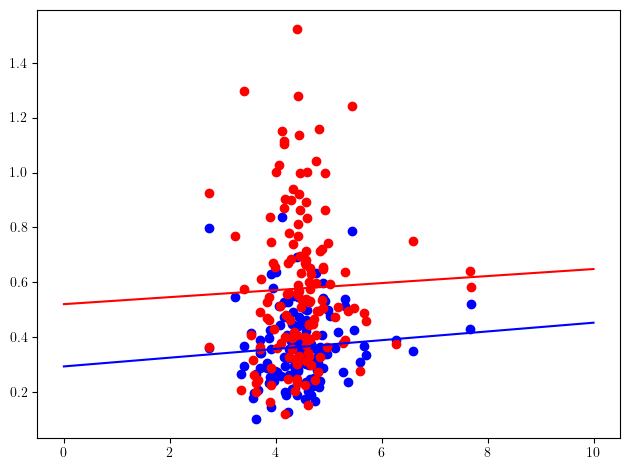

In [29]:
from tabensemb.utils import metric_sklearn

plt.figure()

model = thiswork.model["PHYSICS_NoPCA_KMeans"]
cnt_weights = []
for i in range(np.max(x_cluster["train"]["x_cluster"])):
    is_this_cluster = np.where(x_cluster["train"]["x_cluster"]==i)[0]
    ml_rmse = metric_sklearn(trainer.df.loc[trainer.train_indices[is_this_cluster], trainer.label_name], train_ml_prediction.mean(axis=1).values[is_this_cluster], metric="rmse") if len(is_this_cluster)>0 else np.nan
    phy_rmse = metric_sklearn(trainer.df.loc[trainer.train_indices[is_this_cluster], trainer.label_name], train_phy_prediction.mean(axis=1).values[is_this_cluster], metric="rmse") if len(is_this_cluster)>0 else np.nan
    cnt_weights.append((len(is_this_cluster), np.sqrt(np.sum(np.power(model.clustering.centers[i, :].cpu().numpy(), 2))), train_weights.mean(axis=1).values[is_this_cluster], ml_rmse, phy_rmse, trainer.df.loc[trainer.train_indices[is_this_cluster], trainer.label_name].values.flatten()))
# plt.scatter(x_cluster["train"]["x_cluster"], train_weights.values[:, 3], linewidths=0, alpha=0.2)
x = [np.mean(x[-1]) for x in cnt_weights if x[0]!=0]
y = [x[3] for x in cnt_weights if x[0]!=0]
plt.scatter(x, y, c="b")
r = pearsonr(x, y)
print(r)
pfit = np.polyfit(x, y, 1)
k, b = pfit[0], pfit[1]
plt.plot(np.linspace(0, 10, 3), k*np.linspace(0, 10, 3)+b, color="b", label="Linear fitting (cycle vs ml rmse)")

x = [np.mean(x[-1]) for x in cnt_weights if x[0]!=0]
y = [x[4] for x in cnt_weights if x[0]!=0]
plt.scatter(x, y, c="r")
r = pearsonr(x, y)
print(r)
pfit = np.polyfit(x, y, 1)
k, b = pfit[0], pfit[1]
plt.plot(np.linspace(0, 10, 3), k*np.linspace(0, 10, 3)+b, color="r", label="Linear fitting (cycle vs phy rmse)")

plt.show()
plt.close()

In [16]:
train_ml_prediction

,AutoGluon_LightGBM_NoWrap_NoPCA_KMeans,AutoGluon_CatBoost_NoWrap_NoPCA_KMeans,AutoGluon_XGBoost_NoWrap_NoPCA_KMeans,AutoGluon_Random Forest_NoWrap_NoPCA_KMeans,AutoGluon_Extremely Randomized Trees_NoWrap_NoPCA_KMeans,AutoGluon_K-Nearest Neighbors_NoWrap_NoPCA_KMeans,AutoGluon_Linear Regression_NoWrap_NoPCA_KMeans,AutoGluon_Neural Network with PyTorch_NoWrap_NoPCA_KMeans,AutoGluon_Neural Network with FastAI_NoWrap_NoPCA_KMeans,WideDeep_TabMlp_Wrap_NoPCA_KMeans,...,WideDeep_SelfAttentionMLP_Wrap_NoPCA_KMeans,WideDeep_FTTransformer_Wrap_NoPCA_KMeans,WideDeep_TabPerceiver_Wrap_NoPCA_KMeans,WideDeep_TabFastFormer_Wrap_NoPCA_KMeans,PytorchTabular_Category Embedding_Wrap_NoPCA_KMeans,PytorchTabular_NODE_NoWrap_NoPCA_KMeans,PytorchTabular_TabNet_NoWrap_NoPCA_KMeans,PytorchTabular_TabTransformer_Wrap_NoPCA_KMeans,PytorchTabular_AutoInt_Wrap_NoPCA_KMeans,PytorchTabular_FTTransformer_Wrap_NoPCA_KMeans
5418,3.088925,2.808710,2.742502,2.576417,2.587549,2.571619,4.478415,3.352188,3.449102,3.212282,...,2.981329,3.095524,2.419788,2.622928,3.407803,4.206170,3.991910,4.611339,4.228439,3.194680
2277,4.853487,4.756761,4.747790,4.866711,4.843821,4.983804,4.601192,4.793345,4.624688,4.645997,...,4.668631,5.285590,4.717883,4.818816,4.617522,4.617500,4.761583,4.402366,4.346514,4.784427
1681,5.843359,5.890604,5.905457,5.777328,5.784480,5.384401,5.532083,5.813013,5.828852,5.584435,...,5.720850,5.844490,5.825506,5.973106,5.745231,5.645741,5.484980,5.395914,5.689417,5.736366
4237,5.540947,5.522970,5.545997,5.400661,5.438522,5.149546,5.599256,5.451983,5.315444,4.800869,...,4.179958,5.772474,5.229661,5.332346,5.583669,5.322487,4.762621,6.496385,5.293043,5.064457
3807,3.591957,3.553238,3.473926,3.428077,3.467413,3.695804,3.609262,3.601673,3.581978,3.170005,...,3.577251,3.610455,3.348442,3.642738,3.537729,3.711364,3.629200,3.469687,3.708891,3.623677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3344,4.840092,4.844633,4.754950,4.724827,4.719858,5.127613,4.976954,4.906884,5.026554,4.868922,...,5.328372,4.876677,4.573658,5.385394,4.924516,4.879385,5.077685,4.967656,4.918175,4.806345
3333,5.104378,5.068266,5.012135,5.066772,5.036528,4.408698,4.990624,5.160549,5.324787,5.044357,...,5.394711,5.489343,5.186004,4.995809,5.196682,5.593896,5.305926,4.903160,5.481469,5.307697
716,3.779595,3.826814,3.759659,3.959072,3.958505,3.878477,3.865091,3.829345,3.773518,4.320456,...,3.608258,4.044570,3.761850,4.114937,3.741890,3.677987,4.138600,3.731574,3.765611,4.178280
1162,4.116283,4.155489,4.109954,3.997110,4.088251,4.102536,3.177536,4.196720,4.205813,4.370731,...,3.951490,3.995254,4.472670,4.251527,4.343606,3.879579,4.386691,3.768364,4.180626,4.364663


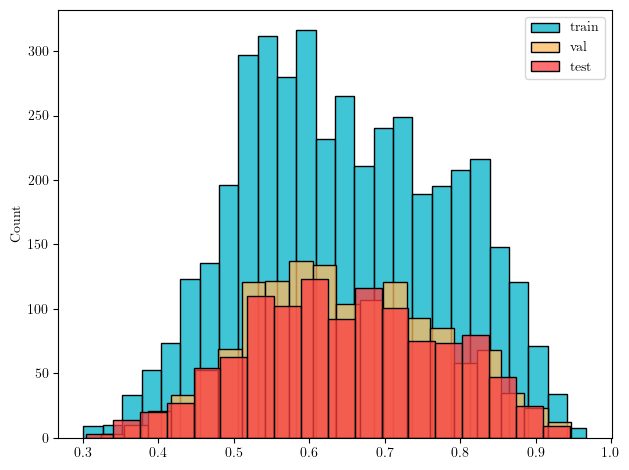

In [4]:
plt.figure()
ax = plt.subplot(111)
sns.histplot(train_weights.mean(axis=1), label="train", ax=ax, color=tabensemb.utils.global_palette[0])
sns.histplot(val_weights.mean(axis=1), label="val", ax=ax, color=tabensemb.utils.global_palette[1])
sns.histplot(test_weights.mean(axis=1), label="test", ax=ax, color=tabensemb.utils.global_palette[2])
plt.legend()
plt.show()
plt.close()

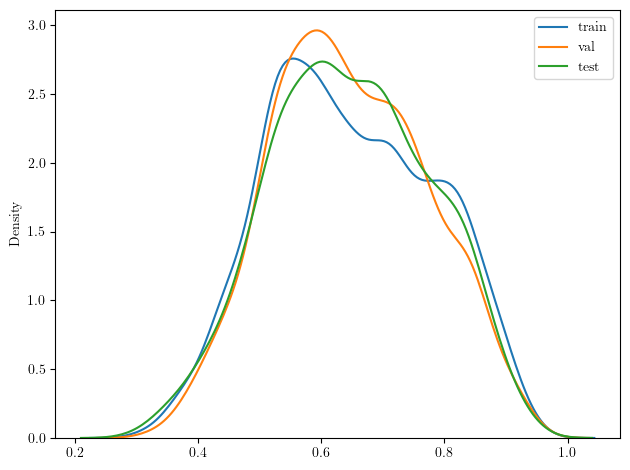

In [5]:
plt.figure()
ax = plt.subplot(111)
sns.kdeplot(train_weights.mean(axis=1), label="train", ax=ax)
sns.kdeplot(val_weights.mean(axis=1), label="val", ax=ax)
sns.kdeplot(test_weights.mean(axis=1), label="test", ax=ax)
plt.legend()
plt.show()
plt.close()

In [98]:
trainer = load_trainer("output/composite_database_10082023/2023-12-12-18-37-31-0_composite StressCycle 316 extracted/trainer.pkl")

In [ ]:
import os
import numpy as np
thiswork = trainer.get_modelbase(program="ThisWork")
train_weights = pd.DataFrame(columns=[x for x in thiswork.get_model_names() if "PHYSICS" not in x], index=trainer.train_indices)
val_weights = pd.DataFrame(columns=[x for x in thiswork.get_model_names() if "PHYSICS" not in x], index=trainer.val_indices)
test_weights = pd.DataFrame(columns=[x for x in thiswork.get_model_names() if "PHYSICS" not in x], index=trainer.test_indices)
for idx, model_name in enumerate(thiswork.get_model_names()):
    if "PHYSICS" not in model_name:
        res = thiswork.inspect_weighted_predictions(model_name=model_name)
        train_weights[model_name] = res["train"]["dl_weight"]
        val_weights[model_name] = res["val"]["dl_weight"]
        test_weights[model_name] = res["test"]["dl_weight"]

In [107]:
st.normaltest(train_weights.mean(axis=1)), st.normaltest(val_weights.mean(axis=1)), st.normaltest(test_weights.mean(axis=1)),

(NormaltestResult(statistic=509.845022771373, pvalue=1.9433901279988194e-111),
 NormaltestResult(statistic=69.89322986861485, pvalue=6.650862553816389e-16),
 NormaltestResult(statistic=199.1292897737213, pvalue=5.749421292015508e-44))

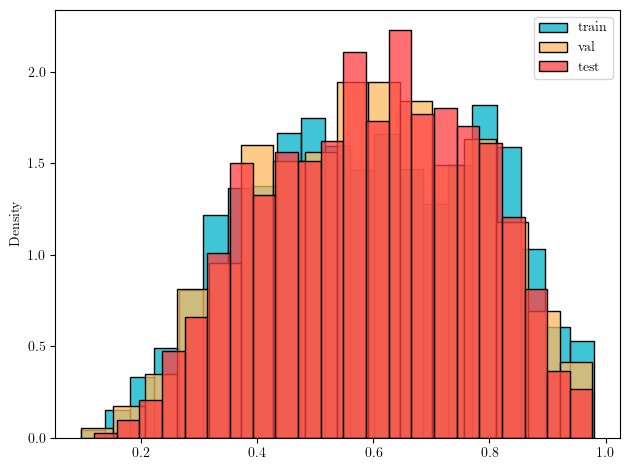

In [102]:
plt.figure()
ax = plt.subplot(111)
sns.histplot(train_weights.mean(axis=1), label="train", ax=ax, color=tabensemb.utils.global_palette[0], stat="density")
sns.histplot(val_weights.mean(axis=1), label="val", ax=ax, color=tabensemb.utils.global_palette[1], stat="density")
sns.histplot(test_weights.mean(axis=1), label="test", ax=ax, color=tabensemb.utils.global_palette[2], stat="density")
plt.legend()
plt.show()
plt.close()

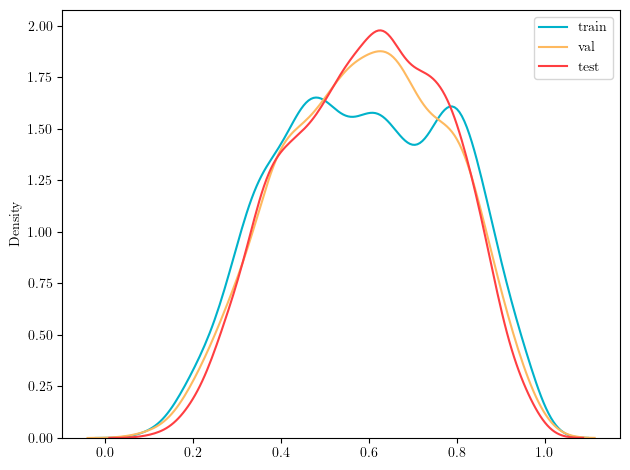

In [104]:
plt.figure()
ax = plt.subplot(111)
sns.kdeplot(train_weights.mean(axis=1), label="train", ax=ax, color=tabensemb.utils.global_palette[0])
sns.kdeplot(val_weights.mean(axis=1), label="val", ax=ax, color=tabensemb.utils.global_palette[1])
sns.kdeplot(test_weights.mean(axis=1), label="test", ax=ax, color=tabensemb.utils.global_palette[2])
plt.legend()
plt.show()
plt.close()

In [110]:
st.ttest_ind(train_weights.mean(axis=1), val_weights.mean(axis=1))

TtestResult(statistic=-0.23169796684770608, pvalue=0.8167839547237274, df=4179.0)